## algo des fourmis fonctionnel V2 : 

## final version 

In [307]:
import numpy as np
import random as rand
import math as m
import networkx as nx
import matplotlib.pyplot as plt
import time
import threading as th
from concurrent.futures import ThreadPoolExecutor

In [266]:
def generate_random_symmetrical_boolean_graph(n):
    while True:
        A = np.triu(np.random.randint(0, 2, (n, n)), 1)
        A += A.T
        if np.all(A.sum(axis=0)):
            return A

In [268]:
def generate_random_collect_points(cities):
    return np.random.randint(0, 2, cities)

In [269]:
def generate_random_delivery_requests(cities, collect_points):
    deliveries = set()
    for i, collect in enumerate(collect_points):
        if collect:
            number_of_drop_points = rand.randint(1, cities)
            deliveries.update((i, rand.randint(0, cities - 1)) for _ in range(number_of_drop_points))
    return sorted(deliveries)

In [270]:
def initialize_pheromones(A, initial_pheromone):
    return np.multiply(A, np.full(A.shape, initial_pheromone))

In [271]:
def update_pheromones(pheromones, paths, deliveries, phi, Temp, amplitude, offset, frequency):
    for path, cost in paths:
        if cost == float('inf'):
            continue
        delivery_count = sum(1 for city in path if any(city in deliveries for obj in deliveries))
        for t, (i, j) in enumerate(zip(path[:-1], path[1:])):
            pheromones[i][j] += (Q / cost) * (delivery_count / len(deliveries)) * (1.0 / C(i, j, t, phi, Temp, amplitude, offset, frequency))
    pheromones *= (1 - RHO)
    return pheromones

In [272]:
def C(i, j, t, phi, Temp, amplitude, offset, frequency):
    return max(1, round((amplitude * m.sin(frequency * t + phi[i][j]) + offset) * Temp[i][j], 4)) if i != j else float('inf')

In [327]:
def construct_path(graph, pheromones, deliveries, start_city, phi, Temp, amplitude, offset, frequency):
    n = len(graph)
    path = [start_city]
    cost = 0
    visited = set([start_city])
    collected_items = set()
    delivered_items = set()
    pending_deliveries = set(deliveries)

    t = 0  # Initialize time for dynamic cost calculation
    all_collect_points = set(i for i, _ in deliveries)

    while pending_deliveries:
        current = path[-1]
        choices = [i for i in range(n) if graph[current][i] > 0 and i != current]

#        filtered_choices = []
#        for i in choices:
#            dynamic_cost = C(current, i, t, phi, Temp, amplitude, offset, frequency)
#            if dynamic_cost != float('inf'):
#                filtered_choices.append(i)

#        if not filtered_choices:
#            filtered_choices = [i for i in range(n) if graph[current][i] > 0 and i != current]

        probabilities = np.array([pheromones[current][i] ** ALPHA * (1.0 / C(current, i, t, phi, Temp, amplitude, offset, frequency)) ** BETA for i in choices])
        total = probabilities.sum()
        if total == 0:
            next_city = start_city
        else:
            probabilities /= total
            next_city = rand.choices(choices, weights=probabilities, k=1)[0]

        if next_city == start_city:
            break

        path.append(next_city)
        visited.add(next_city)
        cost += C(current, next_city, t, phi, Temp, amplitude, offset, frequency)

        # Check and update collections
        if next_city in all_collect_points:
            collected_items.add(next_city)

        # Check and update deliveries
        for item, location in list(pending_deliveries):
            if next_city == location:
                delivered_items.add((item, location))
                pending_deliveries.remove((item, location))
                if next_city == item:
                    collected_items.add(item)

        t += 1
        
    # Ensure all deliveries are met, revisiting cities if necessary
    while pending_deliveries:
        current = path[-1]
        for item, location in list(pending_deliveries):
            if item not in collected_items:
                path.append(item)
                cost += C(path[-2], item, len(path)-2, phi, Temp, amplitude, offset, frequency)
                collected_items.add(item)
            path.append(location)
            cost += C(path[-2], location, len(path)-2, phi, Temp, amplitude, offset, frequency)
            delivered_items.add((item, location))
            pending_deliveries.remove((item, location))

    if len(path) > 1 and path[-1] == path[-2]:
        path.pop()

    return path, cost

In [328]:
def check_delivery_done(R, D):
    return all(item in D for item in R)


In [329]:
def find_backup_path(graph, deliveries, start_city, phi, Temp, amplitude, offset, frequency):
    path = [start_city]
    collected_items = set()
    cost = 0
    for item, location in deliveries:
        if item not in collected_items:
            if path[-1] != item:
                path.append(item)
                cost += C(path[-2], item, len(path)-2, phi, Temp, amplitude, offset, frequency)
            collected_items.add(item)
        if item != location:
            path.append(location)
            cost += C(path[-2], location, len(path)-2, phi, Temp, amplitude, offset, frequency)
    path.append(start_city)
    cost += C(path[-2], start_city, len(path)-2, phi, Temp, amplitude, offset, frequency)
    return path, cost

In [330]:
def ant_colony_optimization(graph, deliveries, phi, Temp, amplitude, offset, frequency):
    start_time = time.time()  # Start the timer
    start_city = rand.randint(0, len(graph) - 1)
    pheromones = initialize_pheromones(graph, 0.1)
    best_path, best_cost = None, float('inf')

    for _ in range(NB_ITERATIONS):
        paths = [construct_path(graph, pheromones, deliveries, start_city, phi, Temp, amplitude, offset, frequency) for _ in range(NB_FOURMIS)]
        valid_paths = [(path, cost) for path, cost in paths if check_delivery_done(deliveries, [(i, j) for i, j in zip(path[:-1], path[1:])])]
        if valid_paths:
            path, cost = min(valid_paths, key=lambda x: x[1])
            if cost < best_cost:
                best_path, best_cost = path, cost
        update_pheromones(pheromones, valid_paths, deliveries, phi, Temp, amplitude, offset, frequency)

    if best_path is None:
        best_path, best_cost = find_backup_path(graph, deliveries, start_city, phi, Temp, amplitude, offset, frequency)
    
    end_time = time.time() 
    time_taken = end_time - start_time  # Calculate the time taken

    return best_path, best_cost, start_city, time_taken

In [331]:
def draw_graph_with_path_and_weights(graph, path, phi, Temp, amplitude, offset, frequency):
    G = nx.Graph()
    for i in range(len(graph)):
        for j in range(i, len(graph[i])):
            if graph[i][j] > 0:
                G.add_edge(i, j, weight=C(i, j, 0, phi, Temp, amplitude, offset, frequency))
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=700)
    path_edges = [(path[i], path[i+1]) for i in range(len(path)-1)]
    nx.draw_networkx_edges(G, pos, edgelist=path_edges, edge_color='r', width=2)
    plt.title('Graph with Path and Edge Weights')
    plt.show()


 Deliveries:
Object from city 0 need to be deliver in city: 0
Object from city 0 need to be deliver in city: 1
Object from city 0 need to be deliver in city: 3
Object from city 0 need to be deliver in city: 5
Object from city 0 need to be deliver in city: 6
Object from city 0 need to be deliver in city: 8
Object from city 4 need to be deliver in city: 1
Object from city 4 need to be deliver in city: 2
Object from city 4 need to be deliver in city: 7
Object from city 4 need to be deliver in city: 9
Object from city 6 need to be deliver in city: 0
Object from city 6 need to be deliver in city: 1
Object from city 6 need to be deliver in city: 2
Object from city 6 need to be deliver in city: 8
Object from city 6 need to be deliver in city: 9
Object from city 7 need to be deliver in city: 0
Object from city 7 need to be deliver in city: 2
Object from city 7 need to be deliver in city: 3
Object from city 7 need to be deliver in city: 5
Object from city 7 need to be deliver in city: 6
Object

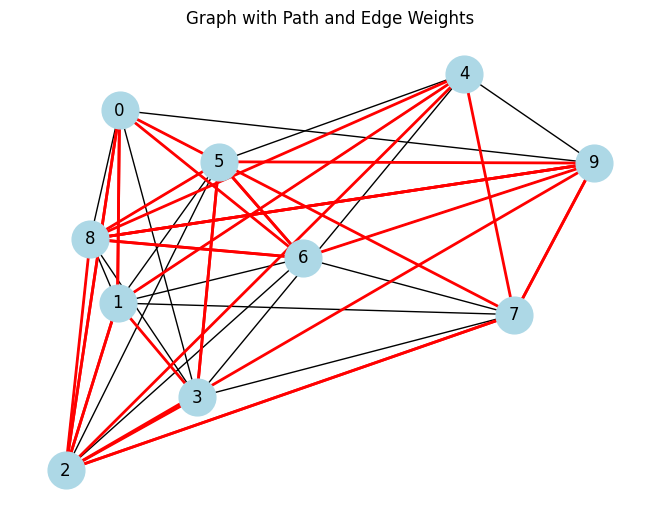

In [336]:
# Constants for the ACO algorithm
NB_FOURMIS = 10 # Number of ants
NB_ITERATIONS = 10  # Number of iterations
ALPHA = 1.0  # Influence of pheromones
BETA = 2.0  # Influence of the heuristic (inverse of the distance)
RHO = 0.5  # Pheromone evaporation rate
Q = 100  # Quantity of pheromones deposited


if __name__ == '__main__':
    n = 10
    phi = np.random.uniform(0.5, 5, (n, n))
    Temp = np.random.uniform(0, 20, (n, n))
    amplitude = 0.7
    offset = 0.3
    frequency = 0.5

    graph = generate_random_symmetrical_boolean_graph(n)
    collect_points = generate_random_collect_points(n)
    deliveries = generate_random_delivery_requests(n, collect_points)
    print("\n Deliveries:")
    for delivery in deliveries:
        print(f"Object from city {int(delivery[0])} need to be deliver in city: {int(delivery[1])}")

    best_path, best_cost, start_city, time_taken = ant_colony_optimization(graph, deliveries, phi, Temp, amplitude, offset, frequency)
    if best_path:
        print("\nBest path starting from city", start_city, ":", best_path)
        print("Cost of best path:", best_cost)
        print("Time taken:", time_taken, "seconds")
        print("\nEdge weights for the best path:")
        for i in range(len(best_path) - 1):
            print(f"Edge from {best_path[i]} to {best_path[i+1]} with weight {C(best_path[i], best_path[i+1], i, phi, Temp, amplitude, offset, frequency)}")
        draw_graph_with_path_and_weights(graph, best_path, phi, Temp, amplitude, offset, frequency)
    else:
        print("No valid path was found that meets all delivery requirements.")

## cas de test fonction du temps dynamique 

In [338]:
def run_test(n, amplitude, offset, frequency):
    phi = np.random.uniform(0.5, 5, (n, n))
    Temp = np.random.uniform(0, 20, (n, n))

    graph = generate_random_symmetrical_boolean_graph(n)
    collect_points = generate_random_collect_points(n)
    deliveries = generate_random_delivery_requests(n, collect_points)
    print("\n Deliveries:")
    for delivery in deliveries:
        print(f"Object from city {int(delivery[0])} need to be deliver in city: {int(delivery[1])}")

    best_path, best_cost, start_city, time_taken = ant_colony_optimization(graph, deliveries, phi, Temp, amplitude, offset, frequency)
    if best_path:
        print("\nBest path starting from city", start_city, ":", best_path)
        print("Cost of best path:", best_cost)
        print("Time taken:", time_taken, "seconds")
        print("\nEdge weights for the best path:")
        for i in range(len(best_path) - 1):
            print(f"Edge from {best_path[i]} to {best_path[i+1]} with weight {C(best_path[i], best_path[i+1], i, phi, Temp, amplitude, offset, frequency)}")
        draw_graph_with_path_and_weights(graph, best_path, phi, Temp, amplitude, offset, frequency)
    else:
        print("No valid path was found that meets all delivery requirements.")


 Deliveries:
Object from city 1 need to be deliver in city: 0
Object from city 1 need to be deliver in city: 2
Object from city 1 need to be deliver in city: 3
Object from city 2 need to be deliver in city: 3
Object from city 2 need to be deliver in city: 4
Object from city 3 need to be deliver in city: 0
Object from city 3 need to be deliver in city: 4
Object from city 4 need to be deliver in city: 2
Object from city 4 need to be deliver in city: 4

Best path starting from city 4 : [4, 1, 0, 2, 3, 2, 3, 4, 3, 0, 4, 2, 4]
Cost of best path: 66.5875
Time taken: 0.04433441162109375 seconds

Edge weights for the best path:
Edge from 4 to 1 with weight 1
Edge from 1 to 0 with weight 8.4187
Edge from 0 to 2 with weight 1.1534
Edge from 2 to 3 with weight 1
Edge from 3 to 2 with weight 1
Edge from 2 to 3 with weight 7.1685
Edge from 3 to 4 with weight 16.2707
Edge from 4 to 3 with weight 14.3195
Edge from 3 to 0 with weight 1
Edge from 0 to 4 with weight 1
Edge from 4 to 2 with weight 3.334

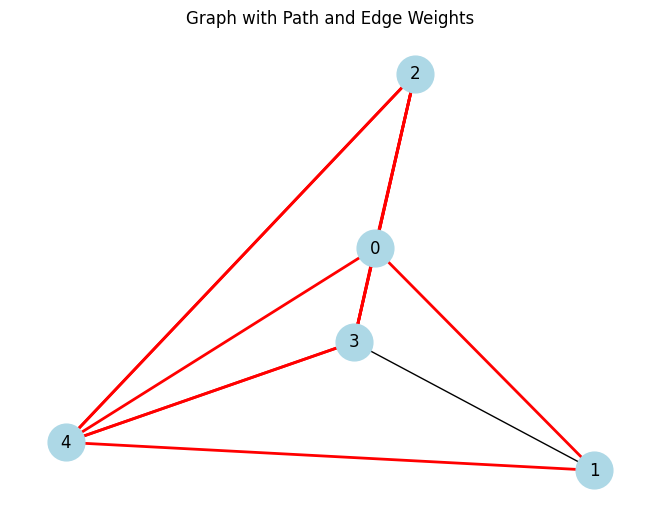

In [339]:
run_test(5, 0.7, 0.3, 0.5)


 Deliveries:
Object from city 2 need to be deliver in city: 2
Object from city 2 need to be deliver in city: 4
Object from city 3 need to be deliver in city: 0
Object from city 3 need to be deliver in city: 1
Object from city 3 need to be deliver in city: 2
Object from city 3 need to be deliver in city: 4
Object from city 4 need to be deliver in city: 1
Object from city 4 need to be deliver in city: 2
Object from city 4 need to be deliver in city: 3

Best path starting from city 4 : [4, 2, 4, 3, 0, 1, 2, 4, 1, 2, 3, 4]
Cost of best path: 60.8177
Time taken: 0.027338266372680664 seconds

Edge weights for the best path:
Edge from 4 to 2 with weight 1
Edge from 2 to 4 with weight 20.4314
Edge from 4 to 3 with weight 4.5544
Edge from 3 to 0 with weight 4.3157
Edge from 0 to 1 with weight 1
Edge from 1 to 2 with weight 8.6462
Edge from 2 to 4 with weight 13.6392
Edge from 4 to 1 with weight 4.2308
Edge from 1 to 2 with weight 1
Edge from 2 to 3 with weight 1
Edge from 3 to 4 with weight 1


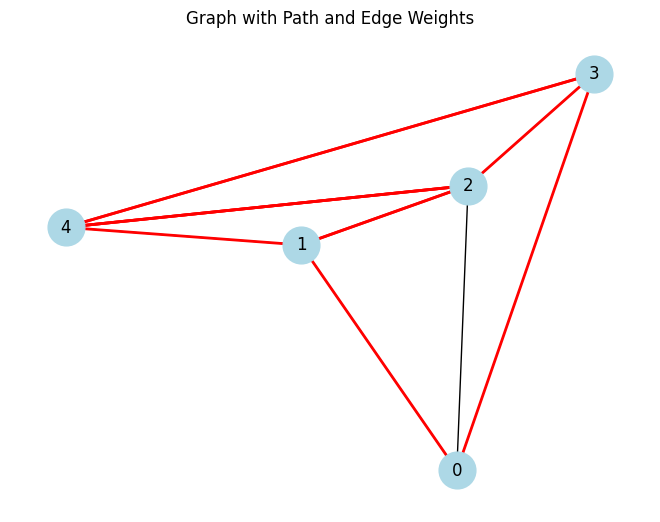

In [340]:
run_test(5, 1.0, 0.5, 1.0)


 Deliveries:
Object from city 0 need to be deliver in city: 0
Object from city 0 need to be deliver in city: 1
Object from city 0 need to be deliver in city: 6
Object from city 0 need to be deliver in city: 7
Object from city 1 need to be deliver in city: 0
Object from city 1 need to be deliver in city: 1
Object from city 1 need to be deliver in city: 3
Object from city 1 need to be deliver in city: 5
Object from city 1 need to be deliver in city: 6
Object from city 1 need to be deliver in city: 7
Object from city 2 need to be deliver in city: 0
Object from city 2 need to be deliver in city: 7
Object from city 4 need to be deliver in city: 0
Object from city 4 need to be deliver in city: 1
Object from city 4 need to be deliver in city: 2
Object from city 4 need to be deliver in city: 5
Object from city 4 need to be deliver in city: 8
Object from city 4 need to be deliver in city: 9
Object from city 5 need to be deliver in city: 0
Object from city 5 need to be deliver in city: 1
Object

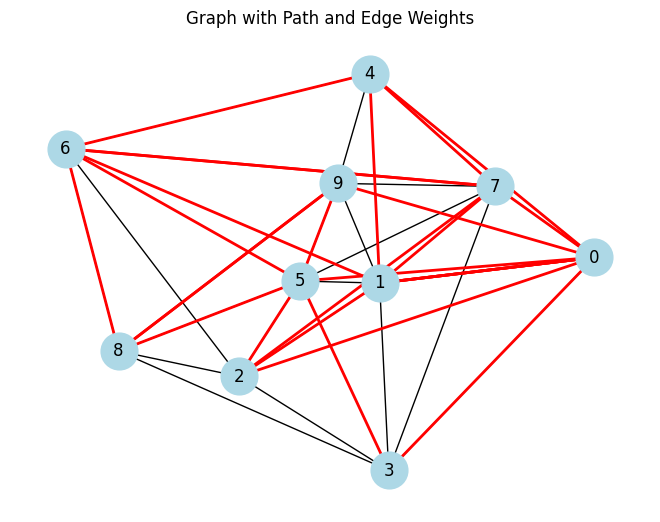

In [341]:
run_test(10, 0.7, 0.3, 0.5)

 # Paramètre n
Description: Ce paramètre détermine le nombre de villes (nœuds) dans le graphe.
Impact:
Taille du graphe: Plus n est grand, plus le graphe est grand, ce qui augmente la complexité du problème.
Nombre de chemins possibles: Une augmentation de n entraîne une augmentation exponentielle du nombre de chemins possibles, rendant le problème plus difficile à résoudre.
Performance: Une plus grande valeur de n nécessite plus de temps de calcul et de mémoire pour explorer les chemins et trouver le meilleur chemin.

# Paramètre amplitude
Description: Ce paramètre contrôle l'amplitude des variations sinusoïdales dans la fonction de coût dynamique C.
Impact:
Variabilité du coût: Une plus grande amplitude signifie que les coûts peuvent varier de manière plus significative en fonction du temps, rendant le problème plus complexe.
Difficulté à prévoir les coûts: Avec une plus grande amplitude, il est plus difficile de prévoir les coûts futurs, ce qui peut compliquer la recherche du chemin optimal.

# Paramètre offset
Description: Ce paramètre contrôle la valeur de décalage dans la fonction de coût dynamique C.
Impact:
Niveau de base du coût: Un offset plus élevé augmente les valeurs de base du coût, rendant tous les trajets plus coûteux.
Difficulté relative des chemins: En ajustant le niveau de base des coûts, ce paramètre peut influencer la difficulté relative de différents chemins, affectant ainsi les décisions prises par l'algorithme.

# Paramètre frequency
Description: Ce paramètre contrôle la fréquence des oscillations dans la fonction de coût dynamique C.
Impact:
Changement rapide des coûts: Une fréquence plus élevée signifie que les coûts changent plus rapidement en fonction du temps, rendant la dynamique des coûts plus volatile.
Complexité temporelle: Des fréquences plus élevées introduisent plus de variations temporelles, ce qui peut compliquer la recherche du chemin optimal car les coûts changent rapidement avec le temps.

## cas de test avec les parametres des fourmis

In [344]:
NB_FOURMIS = 10 # Number of ants
NB_ITERATIONS = 10  # Number of iterations
ALPHA = 1.0  # Influence of pheromones
BETA = 2.0  # Influence of the heuristic (inverse of the distance)
RHO = 0.5  # Pheromone evaporation rate
Q = 100  # Quantity of pheromones deposited

def run_test(n, amplitude, offset, frequency, nb_fourmis, nb_iterations, alpha, beta, rho, q):
    global NB_FOURMIS, NB_ITERATIONS, ALPHA, BETA, RHO, Q
    NB_FOURMIS, NB_ITERATIONS, ALPHA, BETA, RHO, Q = nb_fourmis, nb_iterations, alpha, beta, rho, q
    
    phi = np.random.uniform(0.5, 5, (n, n))
    Temp = np.random.uniform(0, 20, (n, n))

    graph = generate_random_symmetrical_boolean_graph(n)
    collect_points = generate_random_collect_points(n)
    deliveries = generate_random_delivery_requests(n, collect_points)
    print("\n Deliveries:")
    for delivery in deliveries:
        print(f"Object from city {int(delivery[0])} need to be deliver in city: {int(delivery[1])}")

    best_path, best_cost, start_city, time_taken = ant_colony_optimization(graph, deliveries, phi, Temp, amplitude, offset, frequency)
    if best_path:
        print("\nBest path starting from city", start_city, ":", best_path)
        print("Cost of best path:", best_cost)
        print("Time taken:", time_taken, "seconds")
        print("\nEdge weights for the best path:")
        for i in range(len(best_path) - 1):
            print(f"Edge from {best_path[i]} to {best_path[i+1]} with weight {C(best_path[i], best_path[i+1], i, phi, Temp, amplitude, offset, frequency)}")
        draw_graph_with_path_and_weights(graph, best_path, phi, Temp, amplitude, offset, frequency)
    else:
        print("No valid path was found that meets all delivery requirements.")


 Deliveries:
Object from city 0 need to be deliver in city: 0
Object from city 0 need to be deliver in city: 2
Object from city 3 need to be deliver in city: 2

Best path starting from city 4 : [4, 0, 2, 3, 2, 4]
Cost of best path: 19.8192
Time taken: 0.007134675979614258 seconds

Edge weights for the best path:
Edge from 4 to 0 with weight 2.3905
Edge from 0 to 2 with weight 1
Edge from 2 to 3 with weight 14.4287
Edge from 3 to 2 with weight 1
Edge from 2 to 4 with weight 1


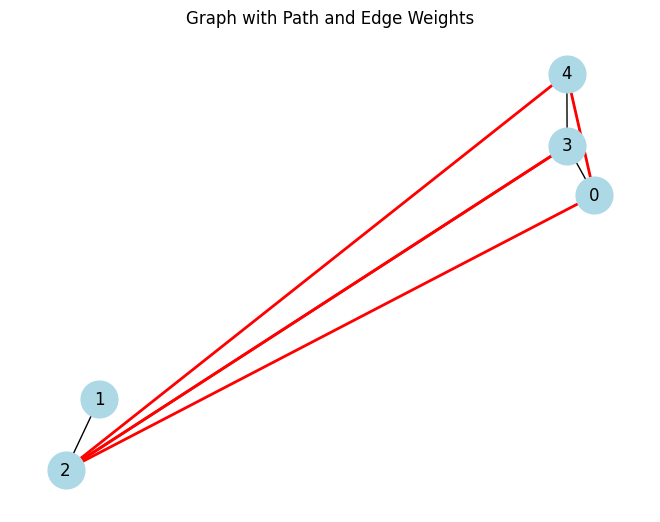

In [345]:
run_test(5, 0.7, 0.3, 0.5, 10, 10, 1.0, 2.0, 0.5, 100)


 Deliveries:
Object from city 1 need to be deliver in city: 0
Object from city 1 need to be deliver in city: 1
Object from city 1 need to be deliver in city: 2
Object from city 2 need to be deliver in city: 0
Object from city 2 need to be deliver in city: 1

Best path starting from city 2 : [2, 1, 0, 2, 0, 1, 2]
Cost of best path: 23.5217
Time taken: 0.03515911102294922 seconds

Edge weights for the best path:
Edge from 2 to 1 with weight 1.5869
Edge from 1 to 0 with weight 13.4349
Edge from 0 to 2 with weight 1
Edge from 2 to 0 with weight 1
Edge from 0 to 1 with weight 1
Edge from 1 to 2 with weight 5.4999


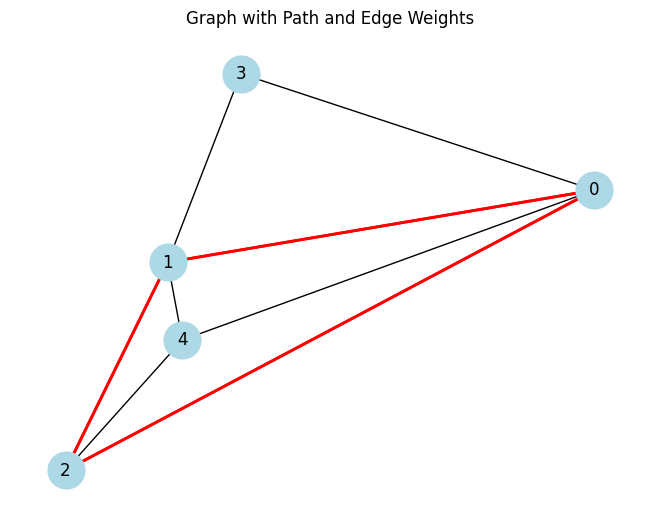

In [347]:
run_test(5, 0.7, 0.3, 0.5, 20, 10, 1.0, 2.0, 0.5, 100)


 Deliveries:
Object from city 0 need to be deliver in city: 0
Object from city 0 need to be deliver in city: 5
Object from city 0 need to be deliver in city: 9
Object from city 1 need to be deliver in city: 0
Object from city 1 need to be deliver in city: 6
Object from city 2 need to be deliver in city: 2
Object from city 2 need to be deliver in city: 9
Object from city 3 need to be deliver in city: 1
Object from city 3 need to be deliver in city: 2
Object from city 3 need to be deliver in city: 3
Object from city 3 need to be deliver in city: 9
Object from city 5 need to be deliver in city: 7
Object from city 5 need to be deliver in city: 9
Object from city 8 need to be deliver in city: 3
Object from city 8 need to be deliver in city: 4
Object from city 9 need to be deliver in city: 1
Object from city 9 need to be deliver in city: 2
Object from city 9 need to be deliver in city: 4
Object from city 9 need to be deliver in city: 5
Object from city 9 need to be deliver in city: 6
Object

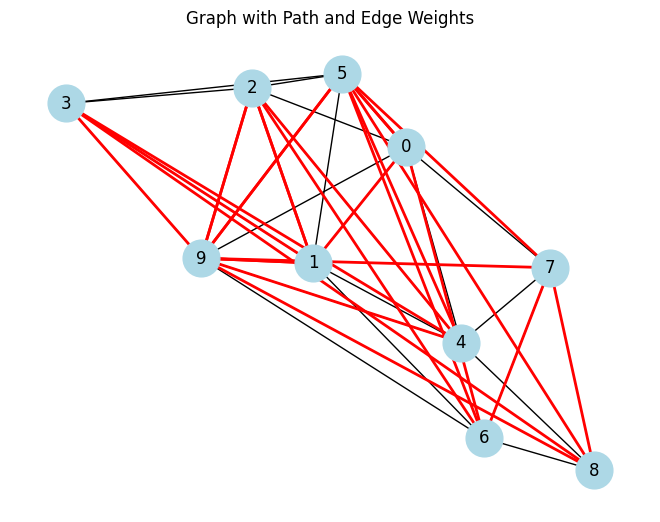

In [348]:
run_test(10, 0.7, 0.3, 0.5, 10, 20, 1.0, 2.0, 0.5, 100)


 Deliveries:
Object from city 0 need to be deliver in city: 1
Object from city 0 need to be deliver in city: 2
Object from city 0 need to be deliver in city: 4
Object from city 0 need to be deliver in city: 5
Object from city 0 need to be deliver in city: 7
Object from city 0 need to be deliver in city: 8
Object from city 1 need to be deliver in city: 2
Object from city 1 need to be deliver in city: 3
Object from city 1 need to be deliver in city: 6
Object from city 1 need to be deliver in city: 7
Object from city 1 need to be deliver in city: 8
Object from city 2 need to be deliver in city: 0
Object from city 2 need to be deliver in city: 3
Object from city 2 need to be deliver in city: 4
Object from city 2 need to be deliver in city: 6
Object from city 2 need to be deliver in city: 7
Object from city 4 need to be deliver in city: 1
Object from city 4 need to be deliver in city: 3
Object from city 4 need to be deliver in city: 5
Object from city 4 need to be deliver in city: 7
Object

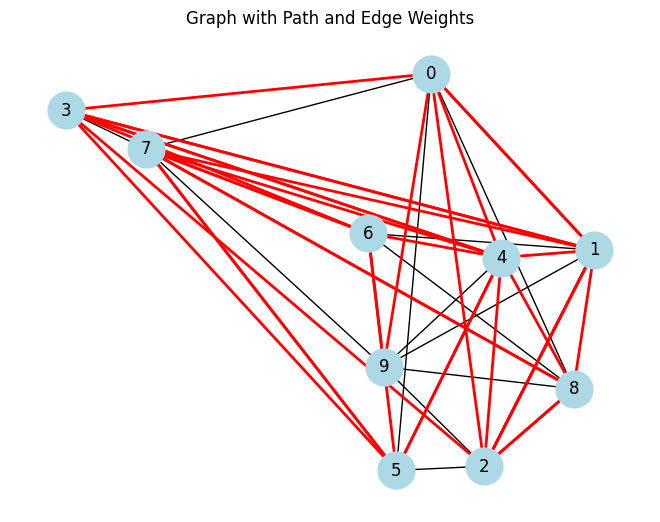

In [349]:
run_test(10, 0.7, 0.3, 0.5, 10, 10, 2.0, 1.0, 0.5, 100)


 Deliveries:
Object from city 1 need to be deliver in city: 0
Object from city 1 need to be deliver in city: 3
Object from city 1 need to be deliver in city: 4
Object from city 1 need to be deliver in city: 5
Object from city 1 need to be deliver in city: 6
Object from city 1 need to be deliver in city: 7
Object from city 1 need to be deliver in city: 8
Object from city 1 need to be deliver in city: 9
Object from city 3 need to be deliver in city: 2
Object from city 3 need to be deliver in city: 3
Object from city 3 need to be deliver in city: 5
Object from city 5 need to be deliver in city: 2
Object from city 5 need to be deliver in city: 5
Object from city 5 need to be deliver in city: 6
Object from city 5 need to be deliver in city: 9
Object from city 7 need to be deliver in city: 3
Object from city 7 need to be deliver in city: 6
Object from city 7 need to be deliver in city: 7
Object from city 8 need to be deliver in city: 4
Object from city 9 need to be deliver in city: 0
Object

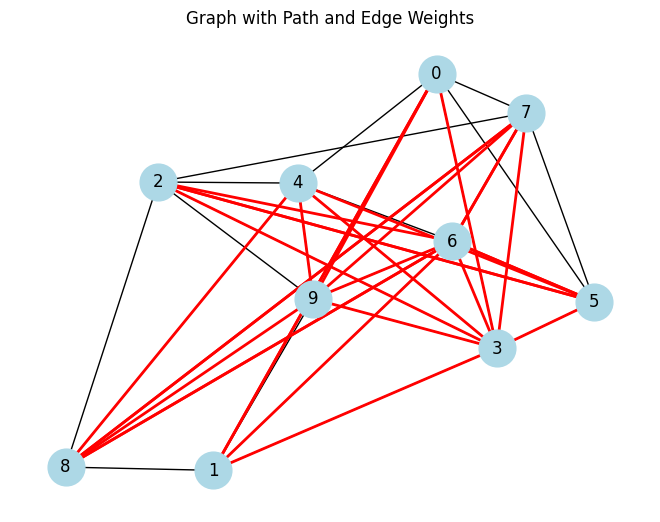

In [350]:
run_test(10, 0.7, 0.3, 0.5, 10, 10, 1.0, 2.0, 0.3, 100)

# Nombre de fourmis :

Tester avec 10 et 20 fourmis pour voir l'impact du nombre de fourmis sur la qualité et le temps de calcul des solutions.


# Nombre d'itérations :

Comparer les performances avec 10 et 20 itérations pour voir comment le nombre d'itérations influence la convergence et la qualité des solutions.


# Alpha et Beta :

Changer les valeurs de alpha et beta pour comprendre leur impact sur l'équilibre entre l'exploitation des chemins connus et l'exploration de nouveaux chemins.

# Rho :

Modifier rho pour observer comment le taux d'évaporation des phéromones influence l'exploration et la convergence de l'algorithme.

# Q :

Tester l'effet de la quantité de phéromones déposées sur la consolidation des solutions trouvées par les fourmis.

## Ajout avec threads

In [314]:
def construct_path(graph, pheromones, deliveries, start_city, phi, Temp, amplitude, offset, frequency, solutions):
    n = len(graph)
    path = [start_city]
    cost = 0
    visited = set([start_city])
    collected_items = set()
    delivered_items = set()
    
    pending_deliveries = set(deliveries)

    t = 0  # Initialize time for dynamic cost calculation
    all_collect_points = set(i for i, _ in deliveries)

    while pending_deliveries:
        current = path[-1]
        choices = [i for i in range(n) if graph[current][i] > 0 and i != current]

#        filtered_choices = []
#        for i in choices:
#            dynamic_cost = C(current, i, t, phi, Temp, amplitude, offset, frequency)
#            if dynamic_cost != float('inf'):
#                filtered_choices.append(i)

#        if not filtered_choices:
#            filtered_choices = [i for i in range(n) if graph[current][i] > 0 and i != current]

        probabilities = np.array([pheromones[current][i] ** ALPHA * (1.0 / C(current, i, t, phi, Temp, amplitude, offset, frequency)) ** BETA for i in choices])
        total = probabilities.sum()
        if total == 0:
            next_city = start_city
        else:
            probabilities /= total
            next_city = rand.choices(choices, weights=probabilities, k=1)[0]

        if next_city == start_city:
            break

        path.append(next_city)
        visited.add(next_city)
        cost += C(current, next_city, t, phi, Temp, amplitude, offset, frequency)

        # Check and update collections
        if next_city in all_collect_points:
            collected_items.add(next_city)

        # Check and update deliveries
        for item, location in list(pending_deliveries):
            if next_city == location:
                delivered_items.add((item, location))
                pending_deliveries.remove((item, location))
                if next_city == item:
                    collected_items.add(item)

        t += 1

    # Ensure all deliveries are met, revisiting cities if necessary
    while pending_deliveries:
        current = path[-1]
        for item, location in list(pending_deliveries):
            if item not in collected_items:
                path.append(item)
                cost += C(path[-2], item, len(path)-2, phi, Temp, amplitude, offset, frequency)
                collected_items.add(item)
            path.append(location)
            cost += C(path[-2], location, len(path)-2, phi, Temp, amplitude, offset, frequency)
            delivered_items.add((item, location))
            pending_deliveries.remove((item, location))

    if len(path) > 1 and path[-1] == path[-2]:
        path.pop()

    solutions.append((path, cost))

In [315]:
def ant_colony_optimization_parallelize(graph, deliveries, phi, Temp, amplitude, offset, frequency):
    start_time = time.time()  # Start the timer
    start_city = rand.randint(0, len(graph) - 1)
    pheromones = initialize_pheromones(graph, 0.1)
    best_path, best_cost = None, float('inf')
    
 
    for _ in range(NB_ITERATIONS):
        threads = []
        path_temp =[]
        with ThreadPoolExecutor(max_workers=NB_FOURMIS) as executor:
            futures = [
                executor.submit(
                  construct_path,
                  graph, pheromones, deliveries, start_city, phi, Temp, amplitude, offset, frequency, path_temp
                )for _ in range(NB_FOURMIS)
              ]

        for future in futures:
            future.result()
        valid_paths = [(path, cost) for path, cost in path_temp if check_delivery_done(deliveries, [(i, j) for i, j in zip(path[:-1], path[1:])])]
        if valid_paths:
            path, cost = min(valid_paths, key=lambda x: x[1])
            if cost < best_cost:
                best_path, best_cost = path, cost
        update_pheromones(pheromones, valid_paths, deliveries, phi, Temp, amplitude, offset, frequency)
        
    if best_path is None:
        best_path, best_cost = find_backup_path(graph, deliveries, start_city, phi, Temp, amplitude, offset, frequency)
    
    end_time = time.time() 
    time_taken = end_time - start_time  # Calculate the time taken

    return best_path, best_cost, start_city, time_taken